no negative sampling  

NN_word = 2000  
num_features = 3

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.
/home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import sys
sys.path.append('/home/admin/github/wordroid.sblo.jp/lib')
from feature_eng import lowcols

In [3]:
import os.path
import sys
import re
import itertools
import csv
import datetime
import pickle
import random
from collections import defaultdict, Counter
import gc

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import gensim
from sklearn.metrics import f1_score, classification_report, confusion_matrix, log_loss
from sklearn.model_selection import train_test_split
import gensim
from keras.preprocessing.sequence import skipgrams
import tensorflow as tf

In [4]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, cmap=cmap, **kwargs)
def scatter(x, y, color, **kwargs):
    plt.scatter(x, y, marker='.')

### create sample data

In [5]:
NN_word = 2000
NN_sentence = 10000
NN_SEG = 7

In [6]:
product_list = [ee+1 for ee in range(NN_word)]
user_list = [ee+1 for ee in range(NN_sentence)]

In [7]:
a, _ = divmod(len(user_list), NN_SEG)
a
cls_user = [int(user_id / (a+1)) for user_id in range(1, 1+len(user_list))]

In [8]:
a, _ = divmod(len(product_list), NN_SEG)
print(a)

cls_prod = [int(prod_id / (a+1)) for prod_id in range(1, 1+len(product_list))]

285


In [9]:
random.seed(0)

X_list = []

for ii in range(len(user_list)):
    cls = cls_user[ii]
    product_group = np.array(product_list)[np.array(cls_prod) == cls]
    nword = random.randint(5, 20)
    prods = random.sample(product_group.tolist(), nword)
    irow = np.zeros((1,NN_word))
    irow[0,np.array(prods)-1] = 1
    X_list.append(irow)

X = np.concatenate(X_list)
print(X.shape)
X

(10000, 2000)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
X_df = pd.DataFrame(X, dtype=int)
X_df.index = ['r'+ee.astype('str') for ee in (np.arange(X_df.shape[0])+1)]
X_df.columns = ['c'+ee.astype('str') for ee in np.arange(X_df.shape[1])+1]
print(X_df.shape)
X_df.head()

(10000, 2000)


c1  c2  c3  c4  c5  c6  c7  c8  c9  c10  ...    c1991  c1992  c1993  \
r1   0   0   0   0   0   0   0   0   0    0  ...        0      0      0   
r2   0   0   0   0   0   0   0   0   0    0  ...        0      0      0   
r3   1   0   0   0   0   0   0   1   0    0  ...        0      0      0   
r4   0   0   0   0   0   0   0   0   0    0  ...        0      0      0   
r5   0   0   0   0   0   0   0   0   0    0  ...        0      0      0   

    c1994  c1995  c1996  c1997  c1998  c1999  c2000  
r1      0      0      0      0      0      0      0  
r2      0      0      0      0      0      0      0  
r3      0      0      0      0      0      0      0  
r4      0      0      0      0      0      0      0  
r5      0      0      0      0      0      0      0  

[5 rows x 2000 columns]

In [11]:
X_df.values.shape

(10000, 2000)

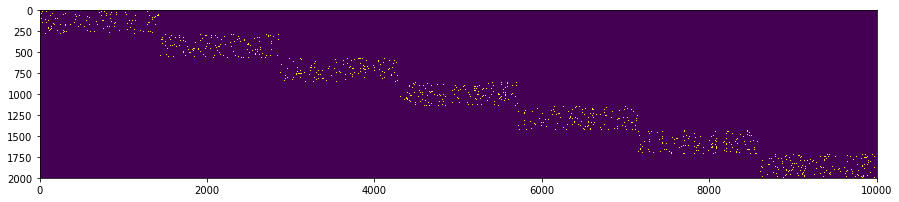

In [12]:
plt.figure(figsize=(15, 15))
plt.imshow(X_df.values.T)

In [13]:
from collections.abc import Sequence

class DocSeq(Sequence):
    '''
    doc_dic  : doc_name (unique)
    word_dic : coding (index=0) is not necessary
    '''
    def __init__(self, df):
        self.df = df
        self.cols = self.df.columns.values
        
        self.doc_dic = gensim.corpora.Dictionary([df.index.values.tolist()], prune_at=None)
        self.word_dic = gensim.corpora.Dictionary([list(self.cols)], prune_at=None)
        
    def __getitem__(self, idx):
        return self._get(idx)
    
    def _get(self, idx):
        try:
            ebid = self.doc_dic[idx]
        except KeyError:
            raise IndexError
        irow = self.df.loc[ebid]
        res = []
        for icol in self.cols:
            if irow[icol] == 1:
                res.append(icol)
        return res
    
    def __len__(self):
        return self.df.shape[0]

In [14]:
doc_seq = DocSeq(X_df)
len(doc_seq)

10000

In [15]:
len(doc_seq.doc_dic)

10000

In [16]:
wd2v = lowcols.WD2vec_low(doc_seq)
wd2v

In [17]:
num_features = 3

models = wd2v.make_model(num_user=len(doc_seq.doc_dic), num_product=NN_word, num_features=num_features)
models['model_gk1'].summary()
models['model_user'].summary()
print('\n\n##################### model >>>')
model = models['model']
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_user (InputLayer)      (None, 1)                 0         
_________________________________________________________________
user_embedding (Embedding)   (None, 1, 3)              30000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3)                 0         
_________________________________________________________________
gkernel1 (GaussianKernel3)   (None, 2000)              6001      
Total params: 36,001
Trainable params: 36,001
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_user (InputLayer)      (None, 1)                 0         
_________________________________________________________________
user_e

In [18]:
wd2v.models['model'].get_layer('user_embedding').get_weights()[0].shape

(10000, 3)

(10000, 3)


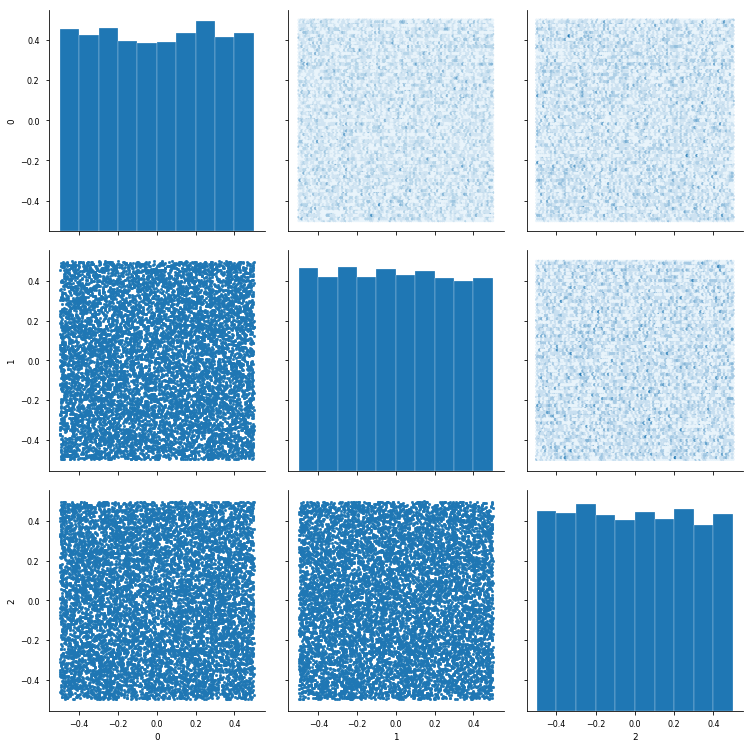

In [19]:
wgt_user = wd2v.get_wgt_byrow(X_df.index.tolist())
# wgt_user = model.get_layer('user_embedding').get_weights()[0]
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(2000, 3)


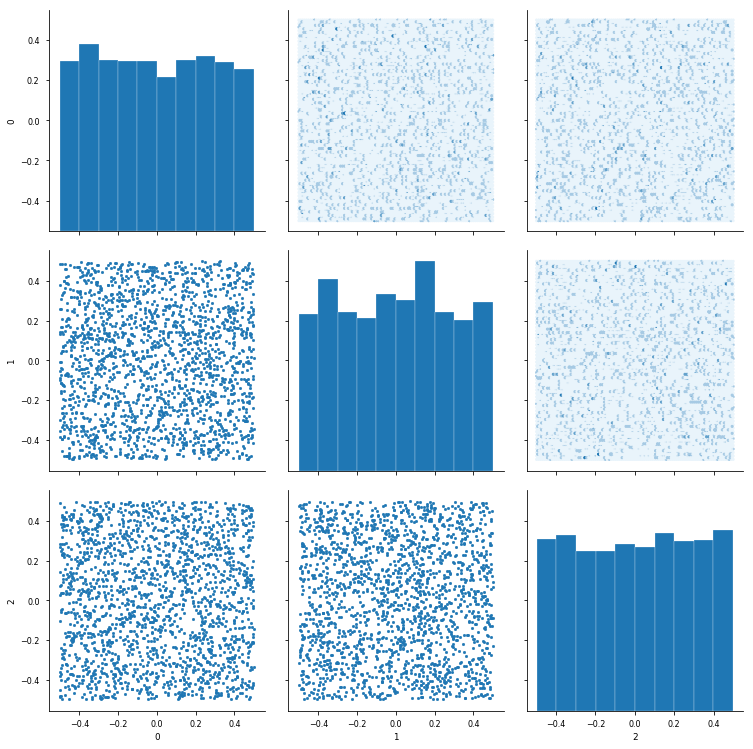

In [20]:
wgt_lm = wd2v.get_wgt_bycol(X_df.columns.tolist())
print(wgt_lm.shape)
df = pd.DataFrame(wgt_lm[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

### 1

In [21]:
wd2v.train(epochs=100, batch_size=32, verbose=2)

/home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
123s - loss: 0.5350 - acc: 0.7432
Epoch 2/100
122s - loss: 0.1695 - acc: 0.9503
Epoch 3/100
122s - loss: 0.0800 - acc: 0.9893
Epoch 4/100
122s - loss: 0.0593 - acc: 0.9936
Epoch 5/100
122s - loss: 0.0536 - acc: 0.9937
Epoch 6/100
122s - loss: 0.0516 - acc: 0.9937
Epoch 7/100
122s - loss: 0.0505 - acc: 0.9937
Epoch 8/100
122s - loss: 0.0496 - acc: 0.9937
Epoch 9/100
122s - loss: 0.0488 - acc: 0.9937
Epoch 10/100
122s - loss: 0.0480 - acc: 0.9937
Epoch 11/100
122s - loss: 0.0472 - acc: 0.9937
Epoch 12/100
122s - loss: 0.0465 - acc: 0.9937
Epoch 13/100
122s - loss: 0.0457 - acc: 0.9937
Epoch 14/100
122s - loss: 0.0450 - acc: 0.9937
Epoch 15/100
122s - loss: 0.0444 - acc: 0.9937
Epoch 16/100
122s - loss: 0.0437 - acc: 0.9937
Epoch 17/100
122s - loss: 0.0432 - acc: 0.9937
Epoch 18/100
122s - loss: 0.0426 - acc: 0.9937
Epoch 19/100
122s - loss: 0.0421 - acc: 0.9937
Epoch 20/100
122s - loss: 0.0417 - acc: 0.9937
Epoch 21/100
122s - loss: 0.0413 - acc: 0.9937
Epoch 22/100
122s - lo

(2000, 3)


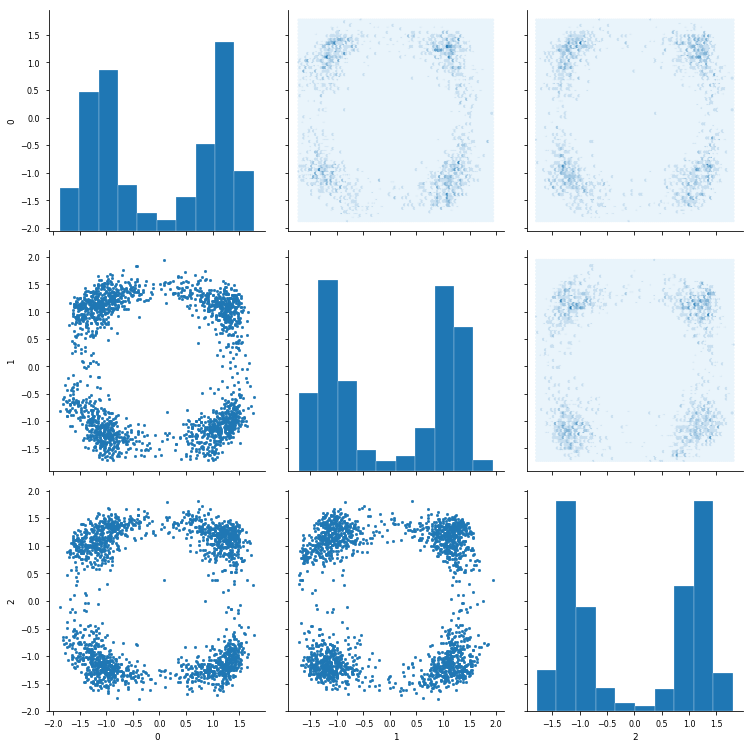

In [22]:
wgt_prod = wd2v.get_wgt_bycol(X_df.columns.tolist())
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(2000, 3)


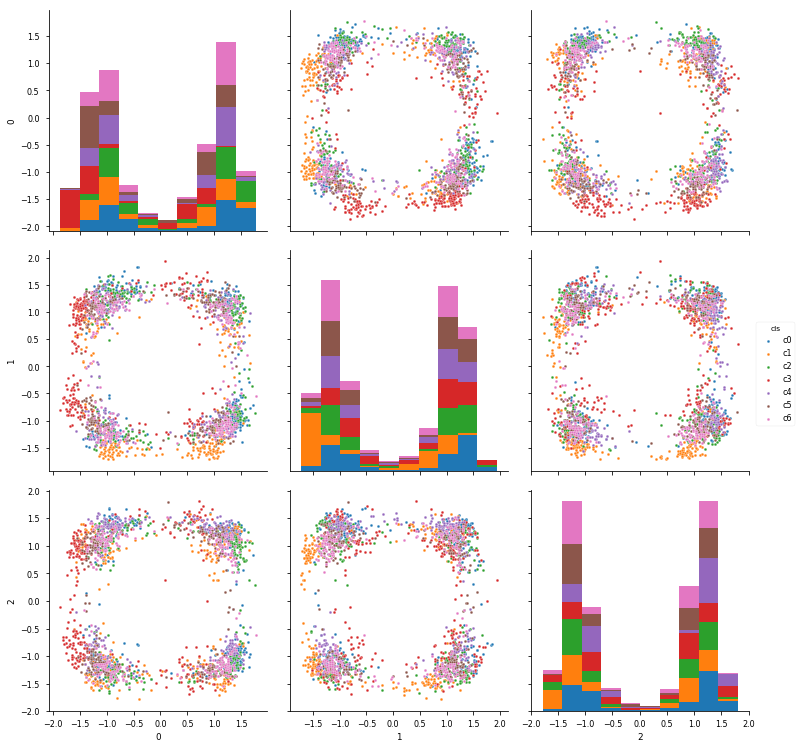

In [23]:
wgt_prod = wd2v.get_wgt_bycol(X_df.columns.tolist())
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_prod]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

(10000, 3)


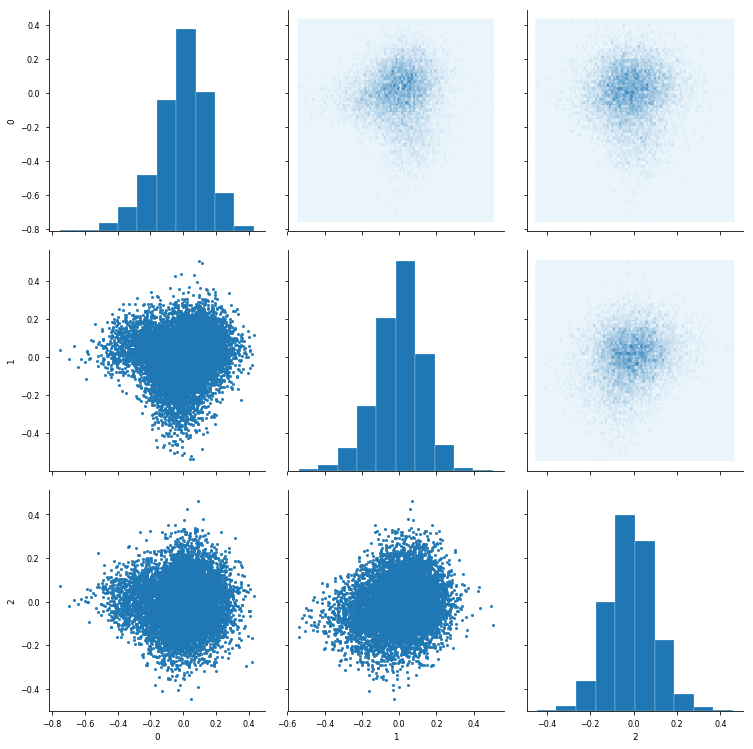

In [24]:
wgt_user = wd2v.get_wgt_byrow(X_df.index.tolist())
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(10000, 3)


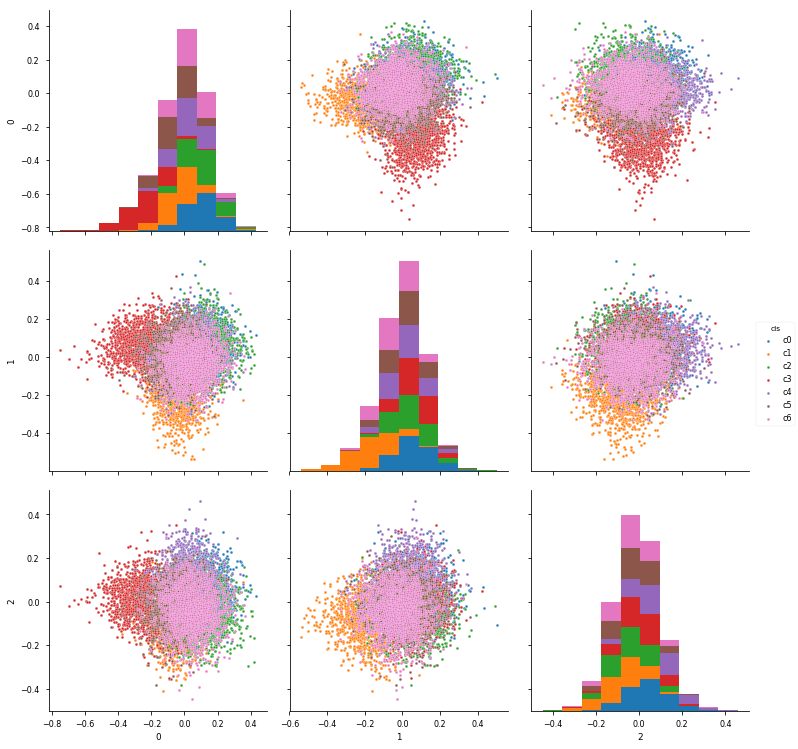

In [25]:
wgt_user = wd2v.get_wgt_byrow(X_df.index.tolist())
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_user]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

In [26]:
'''PCA'''
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(np.vstack([wgt_prod, wgt_user]))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [27]:
f = pca.transform(np.vstack([wgt_prod, wgt_user]))
f.shape

(12000, 2)

In [28]:
df = pd.DataFrame(f)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

0         1 cls
0 -1.411708 -1.325545  c0
1  0.045020  1.666234  c0
2  1.410564  1.495990  c0
3  1.338842  1.557750  c0
4 -0.290161  1.150866  c0

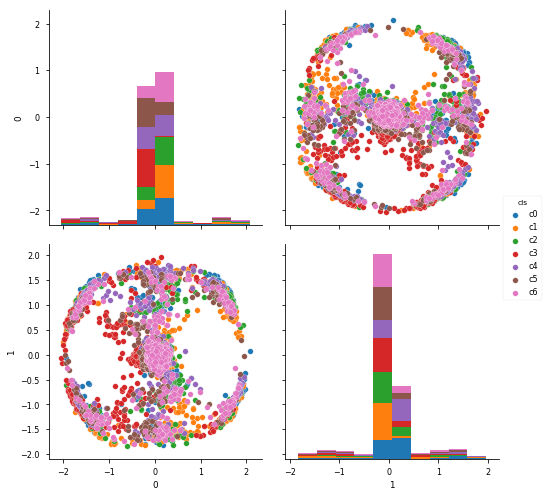

In [29]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')

In [30]:
'''t-SNE'''
from sklearn import manifold
wgt = np.vstack([wgt_prod, wgt_user])
print(wgt.shape)
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(wgt)

(12000, 3)


In [31]:
df = pd.DataFrame(X_tsne)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

0          1 cls
0 -47.456505 -72.735809  c0
1   2.163192  91.342445  c0
2  19.605244  88.625648  c0
3  20.495949  87.284134  c0
4 -35.406590  79.698357  c0

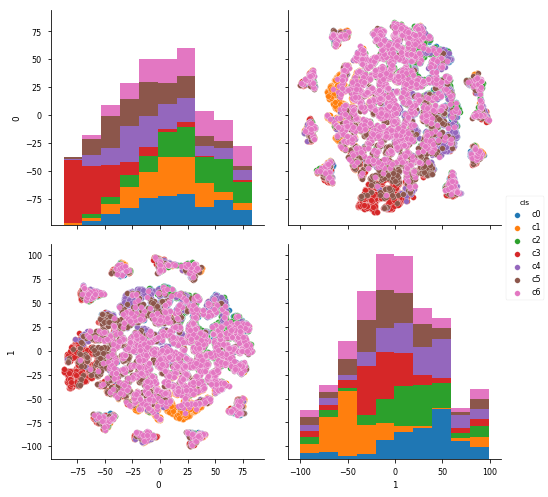

In [32]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')

### 2 (further train)

In [33]:
wd2v.train(epochs=100, batch_size=32, verbose=0)

(2000, 3)


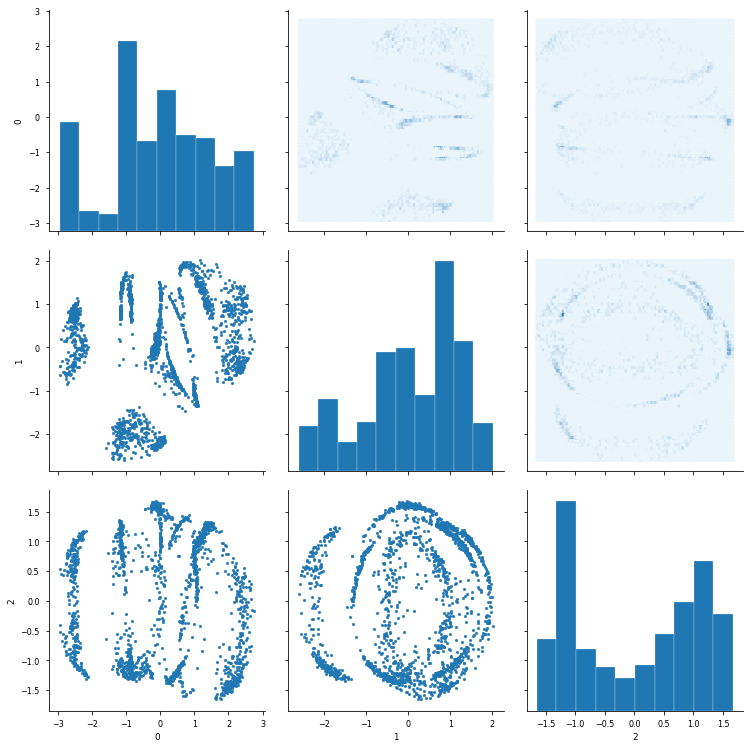

In [34]:
wgt_prod = wd2v.get_wgt_bycol(X_df.columns.tolist())
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(2000, 3)


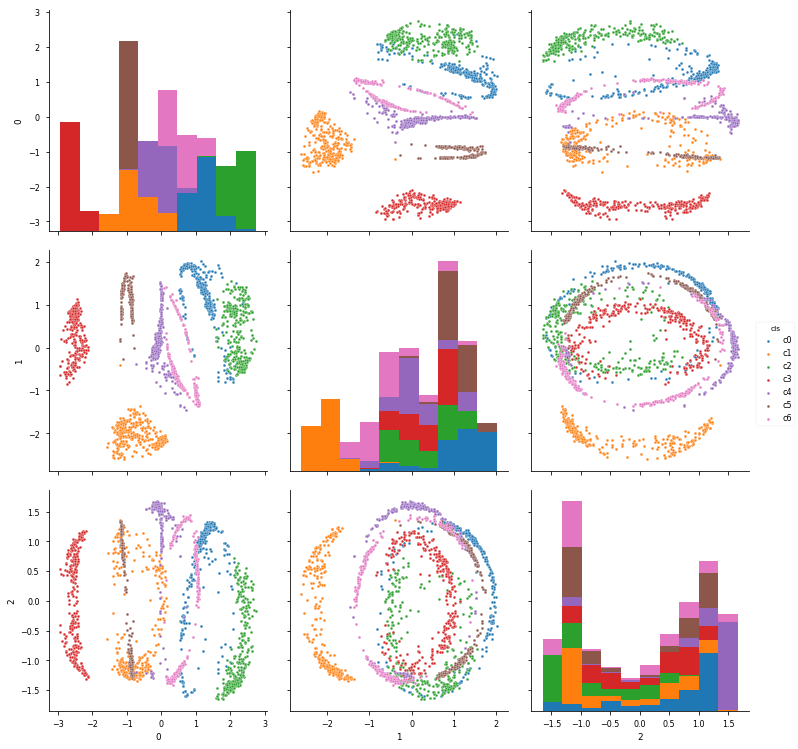

In [35]:
wgt_prod = wd2v.get_wgt_bycol(X_df.columns.tolist())
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_prod]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

(10000, 3)


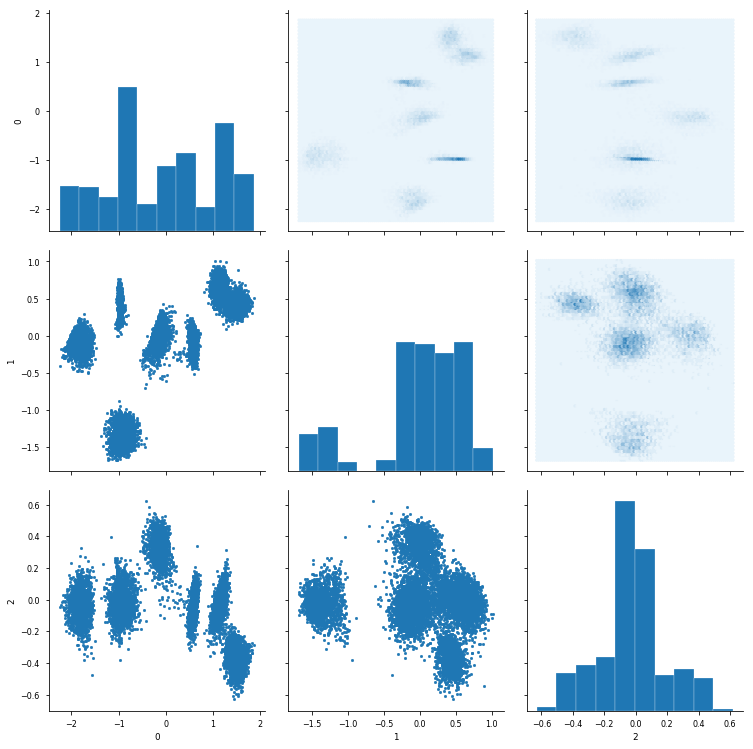

In [36]:
wgt_user = wd2v.get_wgt_byrow(X_df.index.tolist())
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(10000, 3)


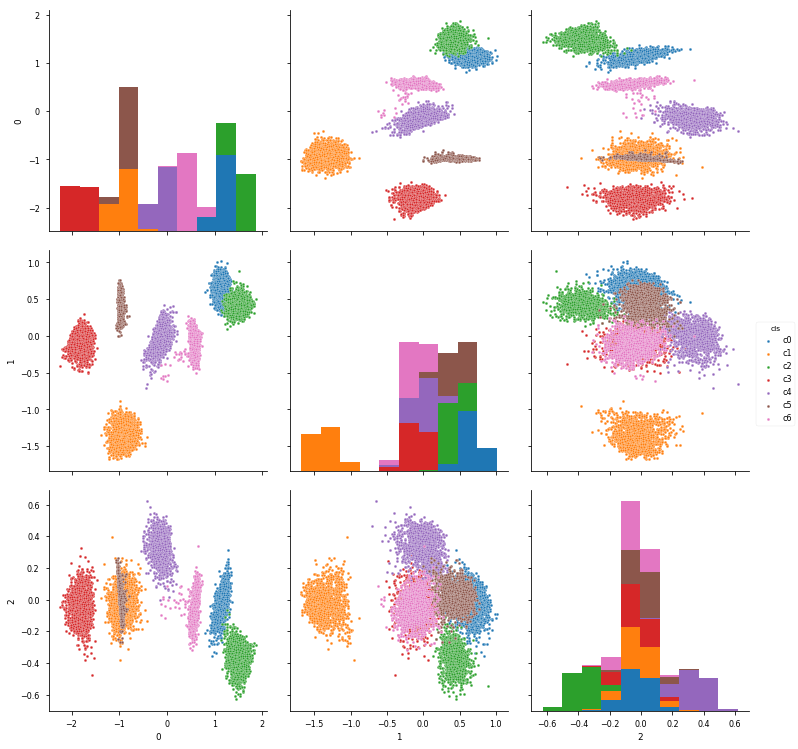

In [37]:
wgt_user = wd2v.get_wgt_byrow(X_df.index.tolist())
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_user]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

In [38]:
'''PCA'''
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(np.vstack([wgt_prod, wgt_user]))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [39]:
f = pca.transform(np.vstack([wgt_prod, wgt_user]))
f.shape

(12000, 2)

In [40]:
df = pd.DataFrame(f)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

0         1 cls
0  1.183226 -1.383804  c0
1  1.573742 -1.080675  c0
2  1.567078 -0.865917  c0
3  1.653710 -0.763654  c0
4  1.531469 -0.709967  c0

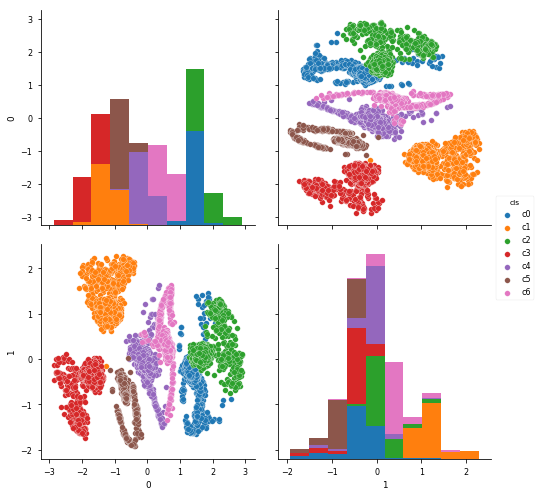

In [41]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')

In [42]:
'''t-SNE'''
from sklearn import manifold
wgt = np.vstack([wgt_prod, wgt_user])
print(wgt.shape)
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(wgt)

(12000, 3)


In [43]:
df = pd.DataFrame(X_tsne)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

0          1 cls
0  25.305885 -77.360992  c0
1  42.508499 -82.125473  c0
2  48.168274 -81.233513  c0
3  49.768879 -79.685394  c0
4  51.041176 -81.141800  c0

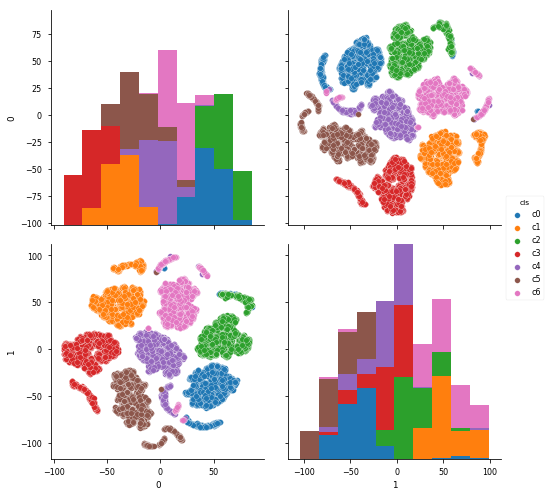

In [44]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')

### 3 (further train)

In [45]:
wd2v.train(epochs=100, batch_size=32, verbose=0)

(2000, 3)


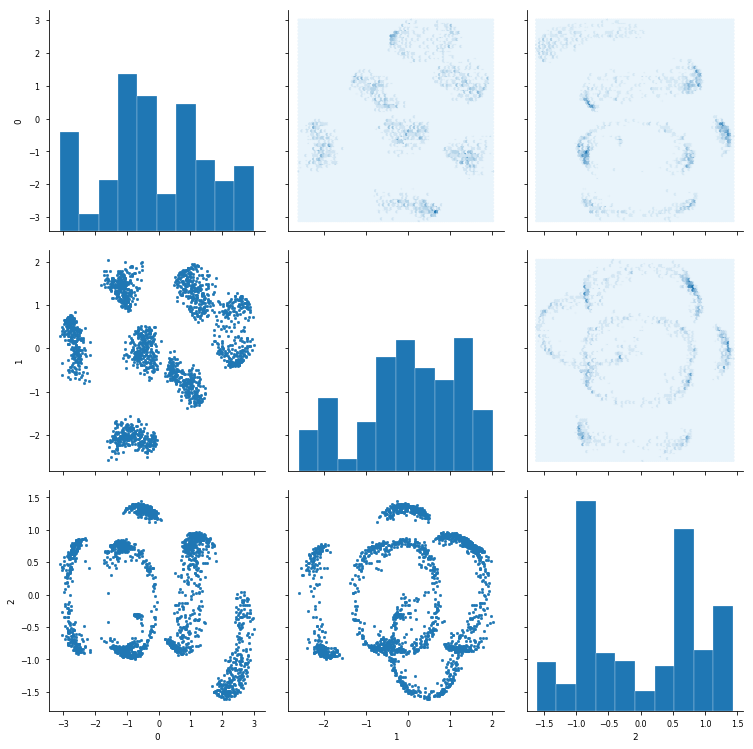

In [46]:
wgt_prod = wd2v.get_wgt_bycol(X_df.columns.tolist())
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(2000, 3)


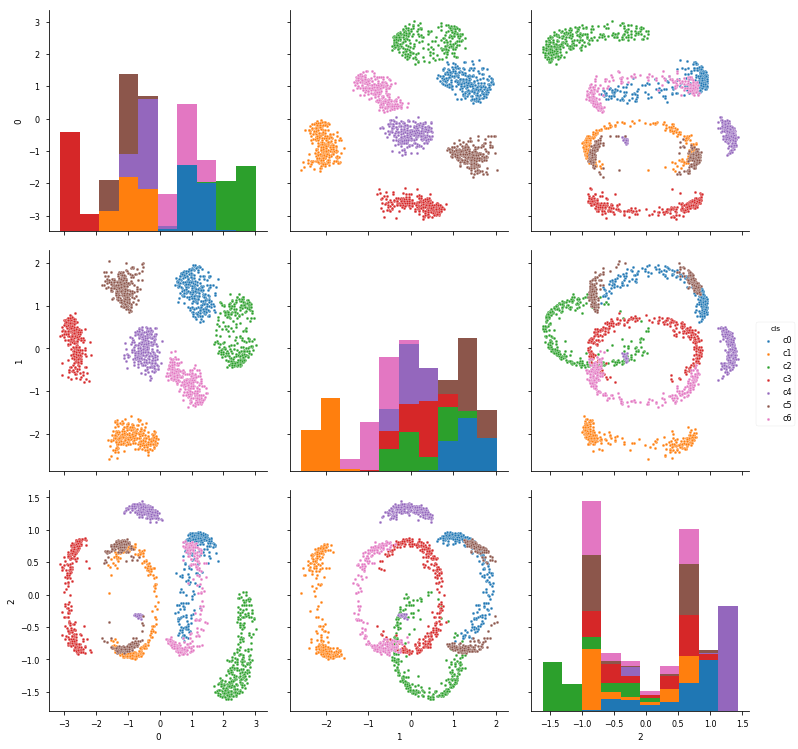

In [47]:
wgt_prod = wd2v.get_wgt_bycol(X_df.columns.tolist())
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_prod]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

(10000, 3)


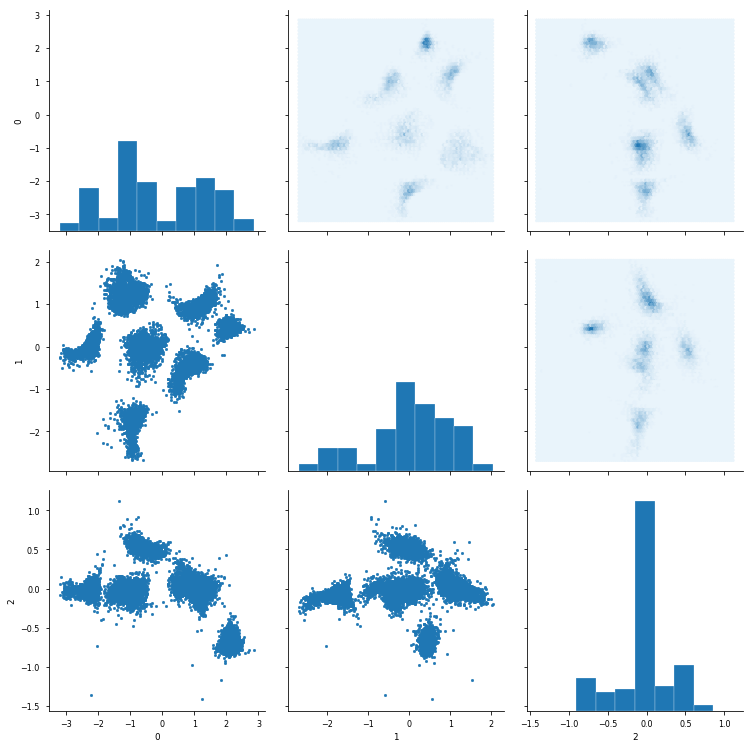

In [48]:
wgt_user = wd2v.get_wgt_byrow(X_df.index.tolist())
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(10000, 3)


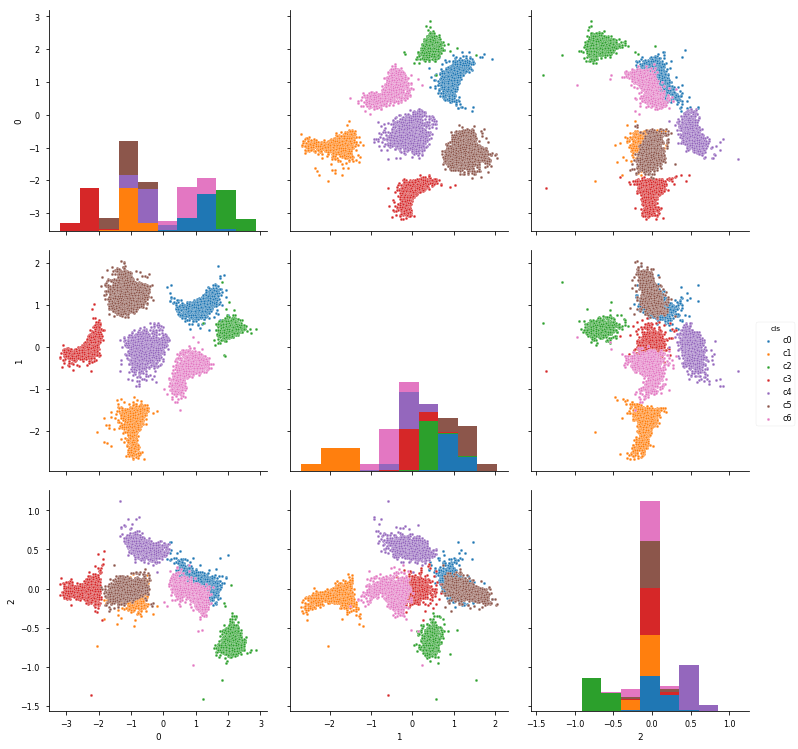

In [49]:
wgt_user = wd2v.get_wgt_byrow(X_df.index.tolist())
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_user]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

In [50]:
'''PCA'''
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(np.vstack([wgt_prod, wgt_user]))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [51]:
f = pca.transform(np.vstack([wgt_prod, wgt_user]))
f.shape

(12000, 2)

In [52]:
df = pd.DataFrame(f)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

0         1 cls
0  1.188341 -1.364184  c0
1  1.639688 -0.894536  c0
2  1.081359 -1.090896  c0
3  1.567356 -1.227507  c0
4  1.163749 -0.723274  c0

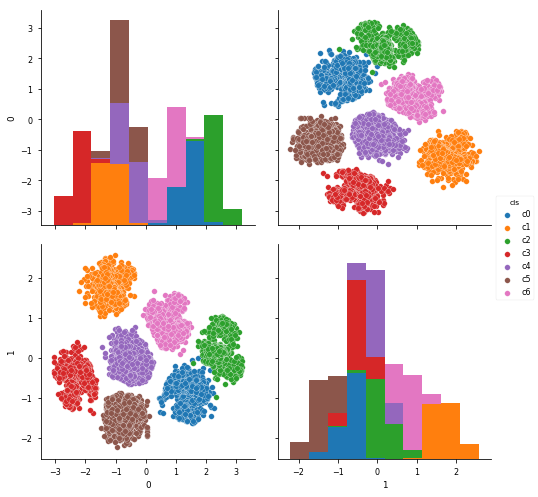

In [53]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')

In [54]:
'''t-SNE'''
from sklearn import manifold
wgt = np.vstack([wgt_prod, wgt_user])
print(wgt.shape)
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(wgt)

(12000, 3)


In [55]:
df = pd.DataFrame(X_tsne)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

0          1 cls
0  22.152409 -92.272888  c0
1  34.899578 -79.857651  c0
2  35.051189 -87.727112  c0
3  32.015194 -83.276863  c0
4  40.802147 -82.850418  c0

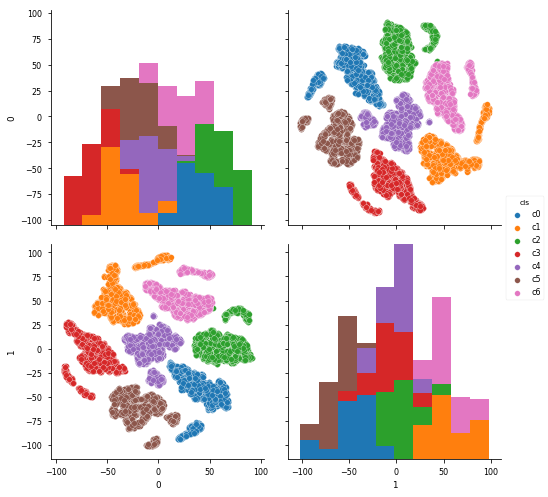

In [56]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')

### 4 (further train)

In [57]:
wd2v.train(epochs=100, batch_size=32, verbose=0)

(2000, 3)


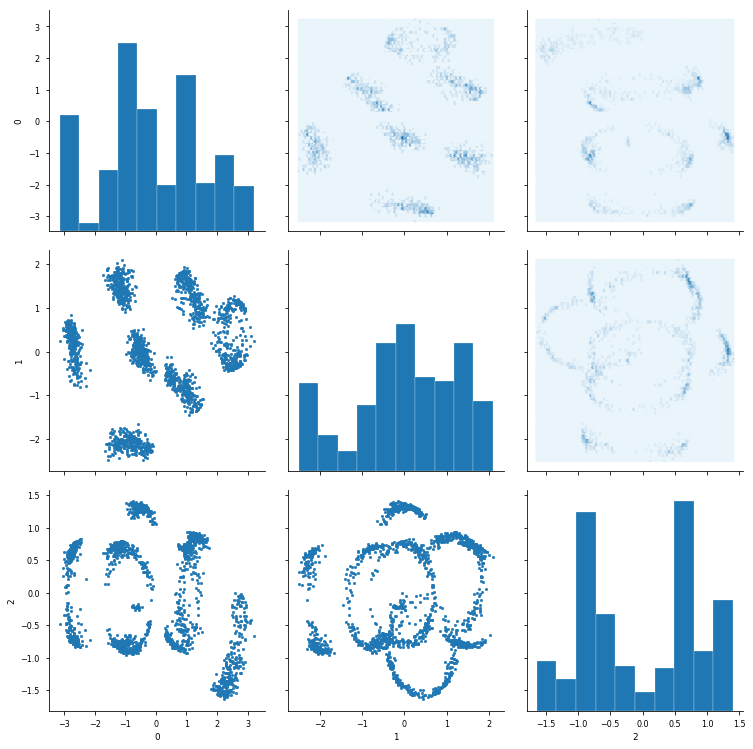

In [58]:
wgt_prod = wd2v.get_wgt_bycol(X_df.columns.tolist())
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(2000, 3)


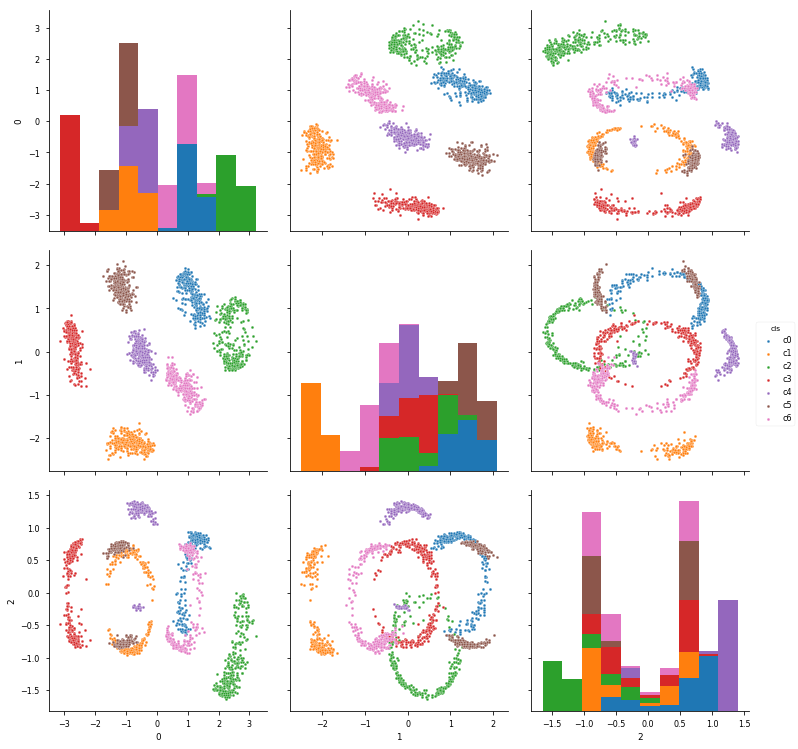

In [59]:
wgt_prod = wd2v.get_wgt_bycol(X_df.columns.tolist())
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_prod]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

(10000, 3)


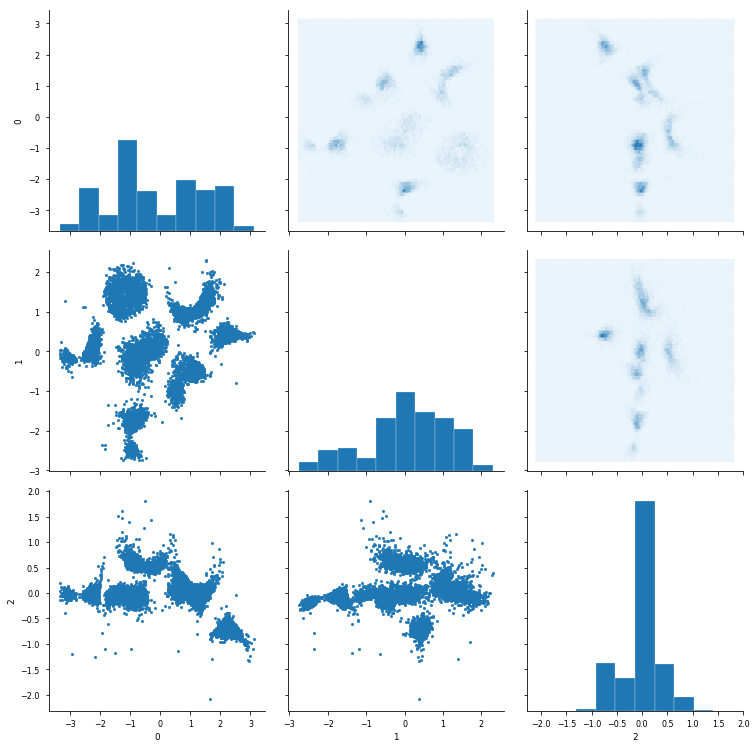

In [60]:
wgt_user = wd2v.get_wgt_byrow(X_df.index.tolist())
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(10000, 3)


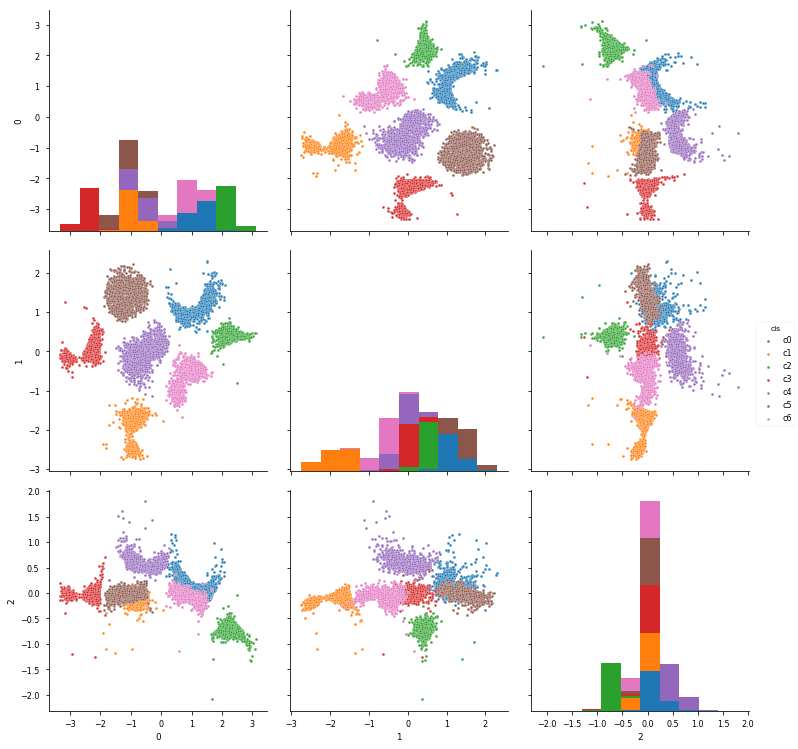

In [61]:
wgt_user = wd2v.get_wgt_byrow(X_df.index.tolist())
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_user]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

In [62]:
'''PCA'''
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(np.vstack([wgt_prod, wgt_user]))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [63]:
f = pca.transform(np.vstack([wgt_prod, wgt_user]))
f.shape

(12000, 2)

In [64]:
df = pd.DataFrame(f)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

0         1 cls
0  1.178783 -1.399508  c0
1  1.532164 -0.899065  c0
2  1.170333 -1.347973  c0
3  1.409374 -1.380743  c0
4  1.275247 -0.851299  c0

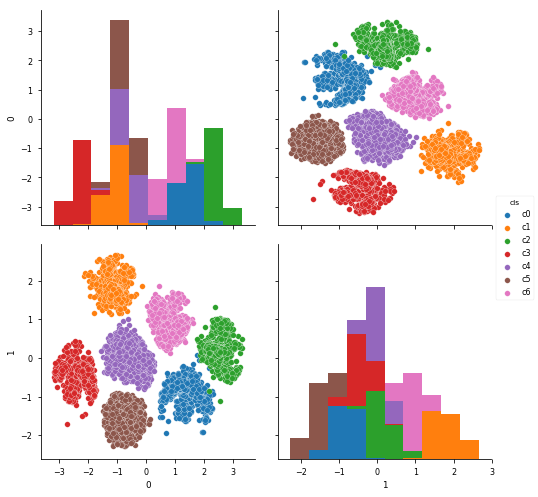

In [65]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')

In [66]:
'''t-SNE'''
from sklearn import manifold
wgt = np.vstack([wgt_prod, wgt_user])
print(wgt.shape)
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(wgt)

(12000, 3)


In [67]:
df = pd.DataFrame(X_tsne)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

0          1 cls
0  26.245516 -86.658333  c0
1  27.928516 -63.669250  c0
2  26.411858 -75.634468  c0
3  28.791477 -75.096428  c0
4  25.422108 -65.520126  c0

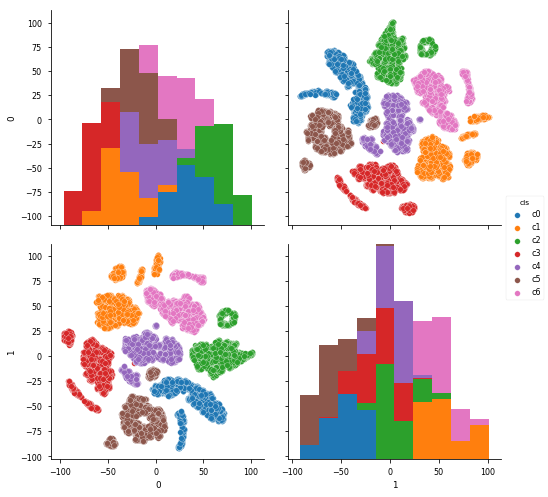

In [68]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')

### 5 (further train)

In [69]:
wd2v.train(epochs=100, batch_size=32, verbose=0)

(2000, 3)


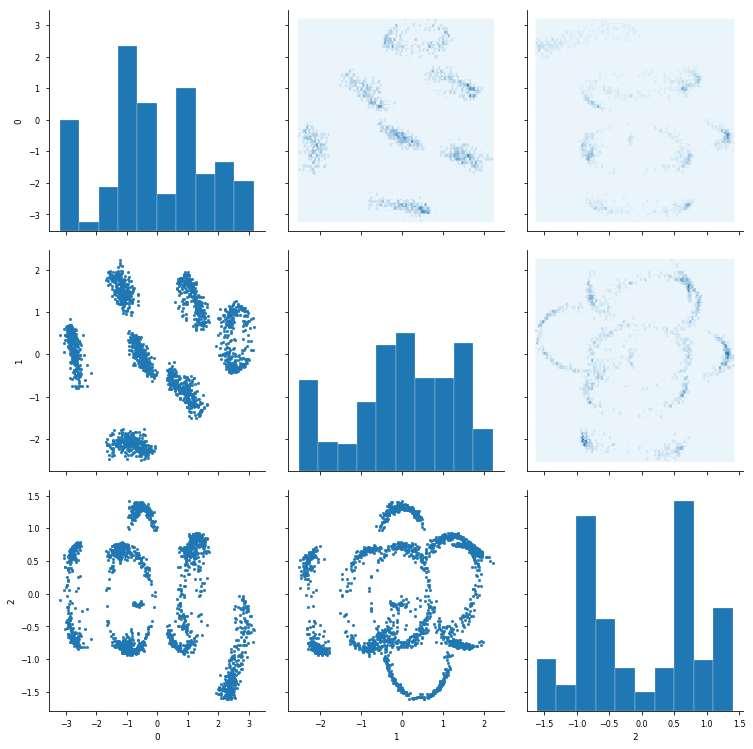

In [70]:
wgt_prod = wd2v.get_wgt_bycol(X_df.columns.tolist())
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(2000, 3)


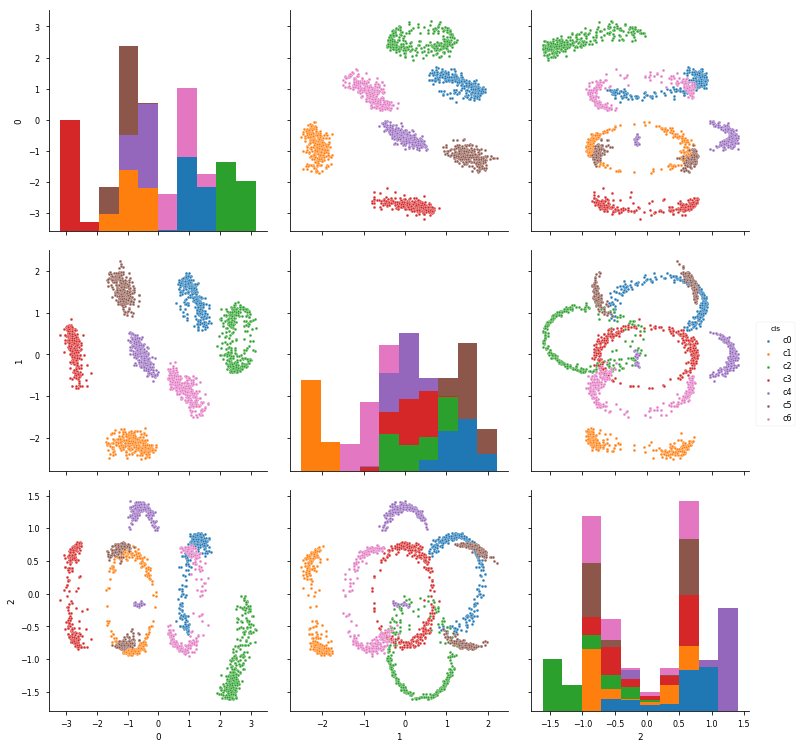

In [71]:
wgt_prod = wd2v.get_wgt_bycol(X_df.columns.tolist())
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_prod]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

(10000, 3)


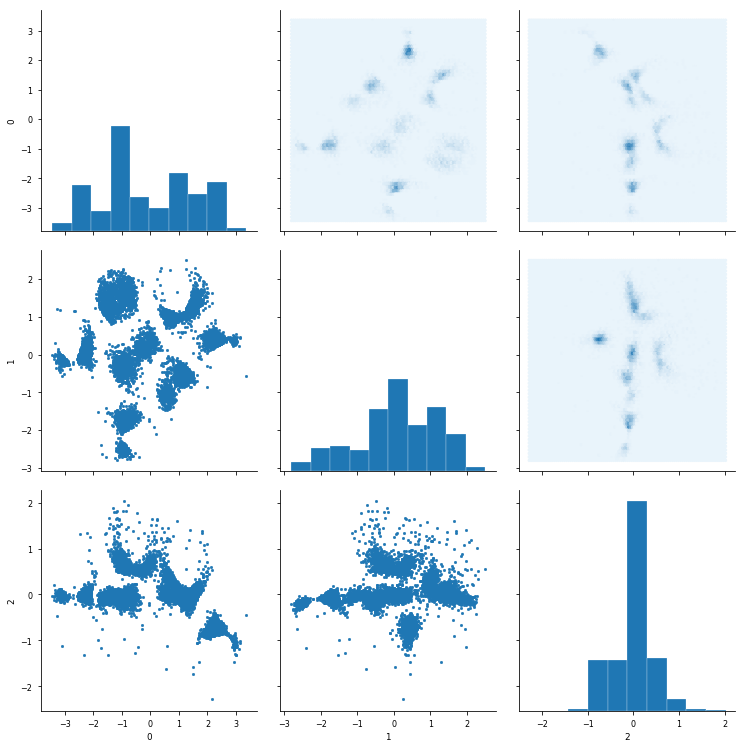

In [72]:
wgt_user = wd2v.get_wgt_byrow(X_df.index.tolist())
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(10000, 3)


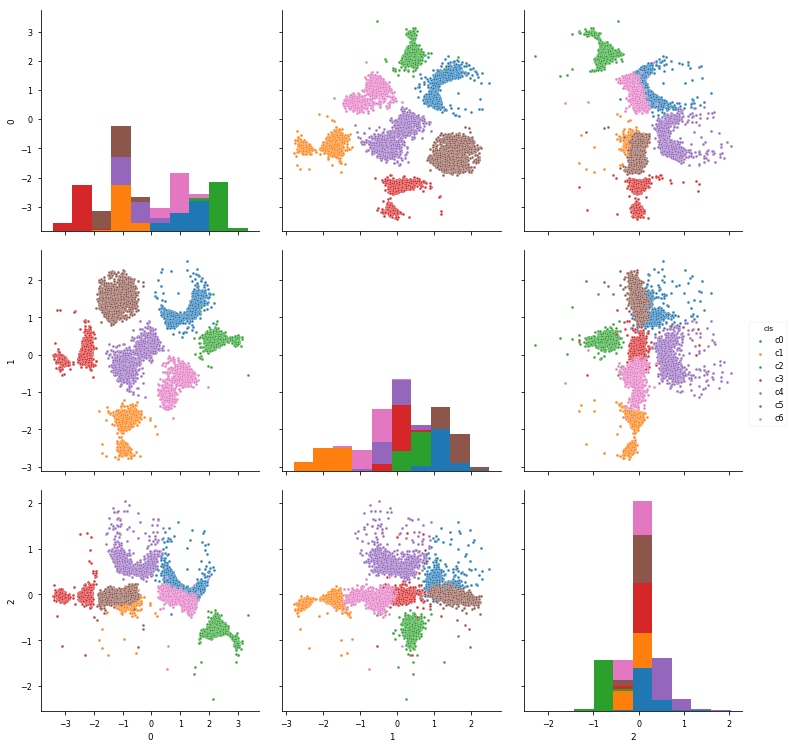

In [73]:
wgt_user = wd2v.get_wgt_byrow(X_df.index.tolist())
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_user]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

In [74]:
'''PCA'''
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(np.vstack([wgt_prod, wgt_user]))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [75]:
f = pca.transform(np.vstack([wgt_prod, wgt_user]))
f.shape

(12000, 2)

In [76]:
df = pd.DataFrame(f)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

0         1 cls
0  1.159775 -1.528561  c0
1  1.534268 -0.906261  c0
2  1.106117 -1.528323  c0
3  1.354734 -1.503438  c0
4  1.288553 -1.046428  c0

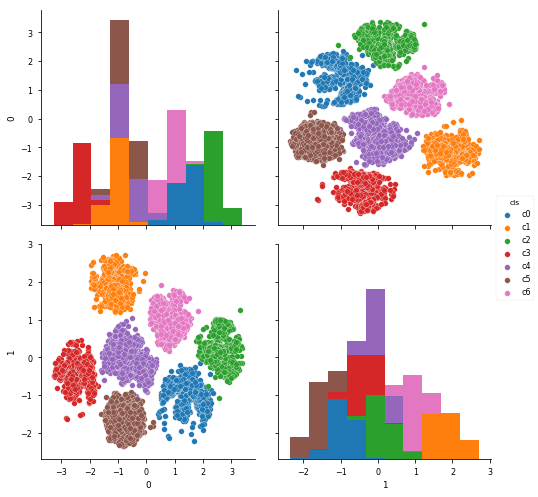

In [77]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')

In [78]:
'''t-SNE'''
from sklearn import manifold
wgt = np.vstack([wgt_prod, wgt_user])
print(wgt.shape)
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(wgt)

(12000, 3)


In [79]:
df = pd.DataFrame(X_tsne)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

0          1 cls
0  14.533251 -75.334427  c0
1  30.110100 -83.365952  c0
2  19.561918 -71.663345  c0
3  22.222853 -71.760216  c0
4  27.827827 -79.604347  c0

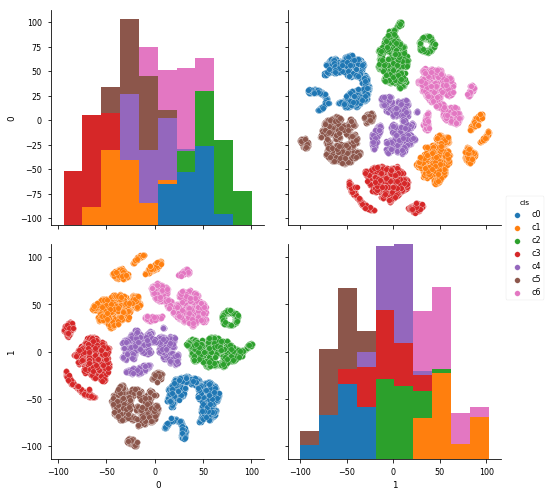

In [80]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')